In [26]:
import pandas as pd
import re
import time
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from numpy import log
from sklearn.metrics import roc_auc_score, roc_curve
import scipy.stats.stats as stats
pd.set_option('display.max_columns', None)


In [2]:
df = pd.read_csv('data/f700.csv',header = 0,encoding = 'latin1')
df.head()

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,pub_rec_bankruptcies,issue_d,earliest_cr_line
0,1,5000,36 months,Fully Paid,10.65%,10+ years,RENT,24000.0,Verified,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,1,NaN,NaN,3,0,9,0.0,Dec-11,Jan-85
1,2,2500,60 months,Charged Off,15.27%,< 1 year,RENT,30000.0,Source Verified,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,5,NaN,NaN,3,0,4,0.0,Dec-11,Apr-99
2,3,2400,36 months,Fully Paid,15.96%,10+ years,RENT,12252.0,Not Verified,NaN,small_business,real estate business,606xx,IL,8.72,0,2,NaN,NaN,2,0,10,0.0,Dec-11,Nov-01
3,4,10000,36 months,Fully Paid,13.49%,10+ years,RENT,49200.0,Source Verified,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,1,35.0,NaN,10,0,37,0.0,Dec-11,Feb-96
4,5,3000,60 months,Fully Paid,12.69%,1 year,RENT,80000.0,Source Verified,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,0,38.0,NaN,15,0,38,0.0,Dec-11,Jan-96


In [3]:
df.isnull().sum()

member_id                     0
loan_amnt                     0
term                          0
loan_status                   0
int_rate                      0
emp_length                 1078
home_ownership                0
annual_inc                    0
verification_status           0
desc                      12967
purpose                       0
title                        11
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
mths_since_last_delinq    25727
mths_since_last_record    36994
open_acc                      0
pub_rec                       0
total_acc                     0
pub_rec_bankruptcies        697
issue_d                       0
earliest_cr_line              0
dtype: int64

In [4]:
df['term'] = df.term.apply(lambda x : int(x.replace('months', '')))
df['bad_id'] = df.loan_status.apply(lambda x: int(x == 'Charged Off'))
df['int_rate'] = df.int_rate.apply(lambda x:  float(x.replace('%', ''))/100)

In [5]:
def year(x):
    if str(x).find('10+') == 0:
        return 11
    elif str(x).find('< 1') == 0:
        return 0
    elif str(x).find('nan') == 0:
        return 1
    else:
        return re.sub(r'\D', '', x)
df['emp_length'] = df.emp_length.apply(lambda x: year(x)).astype('float')


In [6]:
def clean_desc(x):
    if type(x).__name__ == 'float':
        return 'no desc'
    else:
        return 'desc'
df['desc'] = df.desc.apply(lambda x : clean_desc(x))

In [7]:
def clean_time(x):
    if str(x) == 'nan':
        return datetime.datetime.fromtimestamp(
            time.mktime(time.strptime('9900-1', '%Y-%m')))
    else:
        time_map = {
            'Jan': 1,
            'Feb': 2,
            'Mar': 3,
            'Apr': 4,
            'May': 5,
            'Jun': 6,
            'Jul': 7,
            'Aug': 8,
            'Sep': 9,
            'Oct': 10,
            'Nov': 11,
            'Dec': 12
        }
        month = time_map[x[:3]]
        yl = int(x[4:6])
        if yl <= 19:
            year = yl+2000
        else:
            year = 1900+yl
        return datetime.datetime(year, month,1)
df['issue_d'] = df.issue_d.apply(lambda x: clean_time(x))
df['earliest_cr_line'] = df.earliest_cr_line.apply(lambda x:clean_time(x) )

In [8]:
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(-1)
df['mths_since_last_record'] = df['mths_since_last_record'].fillna(-1)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(-1)
df = df.loc[df.term == 36]

In [9]:
df['loan_inc_rate'] = df.loan_amnt /df.annual_inc
def month_total(x, y):
    if x >y:
        gap = relativedelta(x, y)
        mth = gap.months
        yr = gap.years
        return yr*12 + mth
    else:
        return 0
df['month_gap'] = df.apply(lambda x : month_total(x.issue_d, x.earliest_cr_line), axis=1)
df = df.drop('title', axis=1)

In [10]:
train, test = train_test_split(df, test_size = 0.3, random_state = 10)
df.head()

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,pub_rec_bankruptcies,issue_d,earliest_cr_line,bad_id,loan_inc_rate,month_gap
0,1,5000,36,Fully Paid,0.1065,11.0,RENT,24000.0,Verified,desc,credit_card,860xx,AZ,27.65,0,1,-1.0,-1.0,3,0,9,0.0,2011-12-01,1985-01-01,0,0.208333,323
2,3,2400,36,Fully Paid,0.1596,11.0,RENT,12252.0,Not Verified,no desc,small_business,606xx,IL,8.72,0,2,-1.0,-1.0,2,0,10,0.0,2011-12-01,2001-11-01,0,0.195886,121
3,4,10000,36,Fully Paid,0.1349,11.0,RENT,49200.0,Source Verified,desc,other,917xx,CA,20.00,0,1,35.0,-1.0,10,0,37,0.0,2011-12-01,1996-02-01,0,0.203252,190
5,6,5000,36,Fully Paid,0.0790,3.0,RENT,36000.0,Source Verified,no desc,wedding,852xx,AZ,11.20,0,3,-1.0,-1.0,9,0,12,0.0,2011-12-01,2004-11-01,0,0.138889,85
7,8,3000,36,Fully Paid,0.1864,9.0,RENT,48000.0,Source Verified,desc,car,900xx,CA,5.35,0,2,-1.0,-1.0,4,0,4,0.0,2011-12-01,2007-01-01,0,0.062500,59


In [11]:
num_columns = [
    'loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
    'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
    'open_acc', 'pub_rec', 'total_acc', 'loan_inc_rate', 'month_gap',
    'pub_rec_bankruptcies'
]
dis_columns = [
    'home_ownership', 'verification_status', 'purpose', 'addr_state',
    'zip_code', 'desc'
]

In [12]:
more_features = []
less_features = []
for val in dis_columns:
    if len(df[val].unique()) >5:
        more_features.append(val)
    else:
        less_features.append(val)
less_features

['home_ownership', 'verification_status', 'desc']

In [13]:
def val_map(df, val, y):
    df1 = pd.DataFrame()
    df1['total'] = df.groupby(val)[y].count()
    df1['bad'] = df.groupby(val)[y].sum()
    df1['bad_rate'] = df1['bad'] / df1['total']
    df1.reset_index(inplace=True)
    if 0 in df1.bad_rate.values:
        df1 = df1.sort_values('bad_rate')
        df1.index = range(df1.shape[0])
        group1 = [[i] for i in df1[val]]
        lst = []
        for i in range(df1.shape[0]-1):
            group1[i+1] = group1[i] + group1[i+1]
            lst.append(i)
            if df1['bad_rate'][i+1] >0:
                break
        group2 = [group1[i] for i in range(len(group1)) if i not in lst]
        map1 = {}
        for i in range(len(group2)):
            for x in group2[i]:
                map1[x] = 'bin_' + str(i)
        df[val] = df[val].map(map1)
        return df
    elif 1 in df1.bad_rate.values:
        df1 = df1.sort_values('bad_rate', ascending=False)
        df1.index = range(df1.shape[0])
        group1 = [[i] for i in df1[val]]
        lst = []
        for i in range(df1.shape[0]-1):
            group1[i+1] = group1[i] + group1[i+1]
            lst.append(i)
            if df1['bad_rate'][i+1] <1:
                break
        group2 = [group1[i] for i in range(len(group1)) if i not in lst]
        map1 = {}
        for i in range(len(group2)):
            for x in group2[i]:
                map1[x] = 'bin_' + str(i)
        df[val] = df[val].map(map1)
        return df
    else:
        return df
for val in less_features:
    train = val_map(train, val, 'bad_id')
        

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
def val_map2(df, val, y):
    df1 = pd.DataFrame()
    df1['total'] = df.groupby(val)[y].count()
    df1['bad'] = df.groupby(val)[y].sum()
    df1['bad_rate'] = round(df1['bad'] / df1['total'],2)
    by_dict = df1['bad_rate'].to_dict()
    df[val] = df[val].map(by_dict)
    df[val] = df[val].astype('float')
    return df
for val in more_features:
    train = val_map2(train, val, 'bad_id')
num_columns+=more_features
more_features

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


['purpose', 'addr_state', 'zip_code']

In [15]:
def val_map3(df, val, y):
    bad = df[y].sum()
    good = df[y].count() - bad
    df1 = pd.DataFrame()
    df1['bad'] = df.groupby(val)[y].sum()
    df1['good'] = df.groupby(val)[y].count() - df1['bad']
    df1['Woe'] = np.log((df1['bad']/bad)/(df1['good']/good))
    iv = ((df1['bad']/bad - df1['good']/good)*df1['Woe']).sum()
    by_dict = df1['Woe'].to_dict()
    df[val] = df[val].map(by_dict)
    return iv
iv_lst = {}
for val in less_features:
    iv = val_map3(train, val, 'bad_id')
    iv_lst[val+'_iv'] = iv

     

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [16]:
def nomo_cut(X,Y, n=20):
    total = Y.count()
    bad_total = Y.sum()
    good_total = total - bad_total
    r = 0
    while abs(r) <1:
        df1 = pd.DataFrame({'X':X, 'Y':Y, 'cut': pd.qcut(X.rank(method='first'), n, duplicates = 'drop')}).sort_values(by='cut')
        df2 = df1.groupby('cut', as_index=True)
        r, q = stats.spearmanr(df2.X.mean(), df2.Y.mean())
        n = n-1
        if n ==1:
            break
    df3 = pd.DataFrame()
    df3['bad'] = df2.Y.sum()
    df3['good'] = df2.Y.count() - df2.Y.sum()
    df3['bad_rate'] = df2.Y.mean()
    df3['Woe'] = np.log((df3['bad']/bad_total)/(df3['good']/good_total))
    iv = ((df3['bad']/bad_total - df3['good']/good_total)*df3['Woe']).sum()
    print(df3)
    return df3, iv
bad = train['bad_id'].sum()
good = train['bad_id'].count() - bad   

In [17]:
def convert_woe(df, x):
    #     if -1 not in df[x].values:
    df1, iv = nomo_cut(df[x], df['bad_id'], n=5)
    df2 = df1['Woe'].reset_index()
    lst = []
    for x in df[x].rank():
        for i in range(len(df2)):
            if x in df2['cut'][i]:
                y = df2['Woe'][i]
                lst.append(y)
    return iv, lst
lst_1  = [x for x in num_columns if -1 not in train[x].values]
for val in lst_1:
    iv_lst[val+'iv'], lst = convert_woe(train, val)
    train[val] = lst

                       bad  good  bad_rate       Woe
cut                                                 
(0.999, 6789.333]      842  5947  0.124024  0.114620
(6789.333, 13577.667]  744  6044  0.109605 -0.025298
(13577.667, 20366.0]   697  6092  0.102666 -0.098464


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                     bad  good  bad_rate       Woe
cut                                               
(0.999, 5092.25]     259  4833  0.050864 -0.856913
(5092.25, 10183.5]   470  4621  0.092320 -0.216152
(10183.5, 15274.75]  679  4412  0.133373  0.198020
(15274.75, 20366.0]  875  4217  0.171838  0.496827


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                     bad  good  bad_rate       Woe
cut                                               
(0.999, 5092.25]     656  4436  0.128830  0.158134
(5092.25, 10183.5]   551  4540  0.108230 -0.039466
(10183.5, 15274.75]  540  4551  0.106070 -0.062051
(15274.75, 20366.0]  536  4556  0.105263 -0.070584


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                     bad  good  bad_rate       Woe
cut                                               
(0.999, 5092.25]     772  4320  0.151610  0.347456
(5092.25, 10183.5]   586  4505  0.115105  0.029859
(10183.5, 15274.75]  517  4574  0.101552 -0.110619
(15274.75, 20366.0]  408  4684  0.080126 -0.371159


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                     bad  good  bad_rate       Woe
cut                                               
(0.999, 5092.25]     467  4625  0.091712 -0.223420
(5092.25, 10183.5]   552  4539  0.108427 -0.037432
(10183.5, 15274.75]  617  4474  0.121194  0.088313
(15274.75, 20366.0]  647  4445  0.127062  0.142293


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                     bad  good  bad_rate       Woe
cut                                               
(0.999, 10183.5]    1095  9088  0.107532 -0.046719
(10183.5, 20366.0]  1188  8995  0.116665  0.045084


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                       bad  good  bad_rate       Woe
cut                                                 
(0.999, 6789.333]      627  6162  0.092355 -0.215728
(6789.333, 13577.667]  711  6077  0.104744 -0.076112
(13577.667, 20366.0]   945  5844  0.139196  0.247496


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                       bad  good  bad_rate       Woe
cut                                                 
(0.999, 6789.333]      796  5993  0.117248  0.050734
(6789.333, 13577.667]  758  6030  0.111668 -0.004337
(13577.667, 20366.0]   729  6060  0.107380 -0.048309


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                     bad  good  bad_rate       Woe
cut                                               
(0.999, 10183.5]    1101  9082  0.108121 -0.040594
(10183.5, 20366.0]  1182  9001  0.116076  0.039354


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                       bad  good  bad_rate       Woe
cut                                                 
(0.999, 6789.333]      874  5915  0.128738  0.157316
(6789.333, 13577.667]  709  6079  0.104449 -0.079258
(13577.667, 20366.0]   700  6089  0.103108 -0.093677


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                       bad  good  bad_rate       Woe
cut                                                 
(0.999, 6789.333]      688  6101  0.101340 -0.112937
(6789.333, 13577.667]  694  6094  0.102239 -0.103106
(13577.667, 20366.0]   901  5888  0.132715  0.192316


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                     bad  good  bad_rate       Woe
cut                                               
(0.999, 5092.25]     625  4467  0.122742  0.102761
(5092.25, 10183.5]   615  4476  0.120801  0.084619
(10183.5, 15274.75]  563  4528  0.110587 -0.015274
(15274.75, 20366.0]  480  4612  0.094266 -0.193149


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                     bad  good  bad_rate       Woe
cut                                               
(0.999, 5092.25]     410  4682  0.080518 -0.365842
(5092.25, 10183.5]   518  4573  0.101748 -0.108468
(10183.5, 15274.75]  591  4500  0.116087  0.039465
(15274.75, 20366.0]  764  4328  0.150039  0.335189


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                     bad  good  bad_rate       Woe
cut                                               
(0.999, 5092.25]     428  4664  0.084053 -0.319024
(5092.25, 10183.5]   517  4574  0.101552 -0.110619
(10183.5, 15274.75]  634  4457  0.124533  0.119300
(15274.75, 20366.0]  704  4388  0.138256  0.239631


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                     bad  good  bad_rate       Woe
cut                                               
(0.999, 5092.25]     202  4890  0.039670 -1.117198
(5092.25, 10183.5]   452  4639  0.088784 -0.259090
(10183.5, 15274.75]  633  4458  0.124337  0.117497
(15274.75, 20366.0]  996  4096  0.195601  0.655463


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [18]:
def convert_woe2(df, x):
    df1 = df[df[x] != -1]
    df2 = df[df[x] == -1]
    df3, iv = nomo_cut(df1[x], df1['bad_id'], n=5)
    df4 = df3['Woe'].reset_index()
    lst = []
    for x in df1[x].rank():
        for i in range(len(df4)):
            if x in df4['cut'][i]:
                y = df4['Woe'][i]
                lst.append(y)
#     df.loc[df[x] != -1][x] = lst
    bad1 = df2['bad_id'].sum()
    good1 = df2['bad_id'].count() - bad1
    woe_1 = np.log((bad1 / bad) / (good1 / good))
    iv_1 = (bad1 / bad - good1 / good)*woe_1
#     df.loc[df[x] == -1][x] = woe_1
    iv = iv + iv_1
    return lst, woe_1, iv
lst_2 = [x for x in num_columns if -1 in train[x].values]
for val in lst_2:
    lst, woe1, iv_lst[val+'_iv'] = convert_woe2(train, val)
    train.loc[train[val] != -1, val] = lst
    train.loc[train[val] == -1, val] = woe1

 

                  bad  good  bad_rate       Woe
cut                                            
(0.999, 3640.5]   466  3174  0.128022  0.050148
(3640.5, 7280.0]  426  3214  0.117033 -0.052122


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                 bad  good  bad_rate       Woe
cut                                           
(0.999, 760.5]   132   628  0.173684 -0.009141
(760.5, 1520.0]  134   626  0.176316  0.009087
                    bad  good  bad_rate       Woe
cut                                              
(0.999, 9947.5]    1074  8873  0.107972 -0.028897
(9947.5, 19894.0]  1130  8817  0.113602  0.028262


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


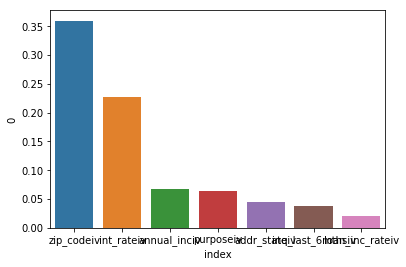

In [19]:
high_iv = {k:v for k, v in iv_lst.items() if v > 0.02}
df_graph = pd.Series(high_iv).reset_index().sort_values(by = 0, ascending=False)
sns.barplot(df_graph.iloc[:, 0], df_graph.iloc[:, 1])

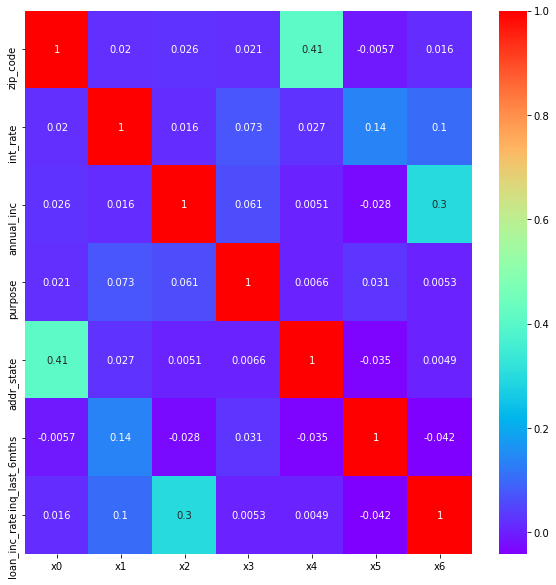

In [20]:
final_lst = df_graph['index'].tolist()
final_lst = [x[:-2] for x in final_lst]
x_train = train[final_lst]
fig = plt.figure(figsize=(10, 10))
corr = x_train.corr()
sns.heatmap(
    corr,
    xticklabels=['x' + str(m) for m in range(7)],
    cmap='rainbow',
    annot=True)
plt.show()

In [21]:
X = np.matrix(x_train)
vif_lst = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
max_VIF = max(vif_lst)
max_VIF

1.2438285086804624

In [22]:
for val in less_features:
    test = val_map(test, val, 'bad_id')
for val in more_features:
    test = val_map2(test, val, 'bad_id')
    iv_2 = val_map3(test,val, 'bad_id')
lst_3  = [x for x in num_columns if -1 not in test[x].values]
for val in lst_3:
    iv_4, lst = convert_woe(test, val)
    test[val] = lst

lst_4 = [x for x in num_columns if -1 in test[x].values]
for val in lst_4:
    lst2, woe2, iv2 = convert_woe2(test, val)
    test.loc[test[val] != -1, val] = lst2
    test.loc[test[val] == -1, val] = woe2

y_train = train['bad_id']
x_test = test[final_lst]
y_test = test['bad_id']   

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

                  bad  good  bad_rate       Woe
cut                                            
(0.999, 4365.0]   484  3881  0.110882  0.028065
(4365.0, 8729.0]  460  3904  0.105408 -0.028703


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 2183.0]   111  2072  0.050847 -0.816911
(2183.0, 4365.0]  199  1983  0.091201 -0.189233
(4365.0, 6547.0]  260  1922  0.119157  0.109388
(6547.0, 8729.0]  374  1808  0.171402  0.534107


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 4365.0]   465  3900  0.106529 -0.016867
(4365.0, 8729.0]  479  3885  0.109762  0.016650


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 2183.0]   321  1862  0.147045  0.351863
(2183.0, 4365.0]  246  1936  0.112741  0.046780
(4365.0, 6547.0]  200  1982  0.091659 -0.183716
(6547.0, 8729.0]  177  2005  0.081118 -0.317422


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                      bad  good  bad_rate       Woe
cut                                                
(0.999, 2910.333]     302  2608  0.103780 -0.046084
(2910.333, 5819.667]  308  2601  0.105878 -0.023724
(5819.667, 8729.0]    334  2576  0.114777  0.066976


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 4365.0]   458  3907  0.104926 -0.033828
(4365.0, 8729.0]  486  3878  0.111366  0.032962


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 2183.0]   193  1990  0.088410 -0.223372
(2183.0, 4365.0]  199  1983  0.091201 -0.189233
(4365.0, 6547.0]  266  1916  0.121907  0.135329
(6547.0, 8729.0]  286  1896  0.131072  0.218318


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 2183.0]   269  1914  0.123225  0.147589
(2183.0, 4365.0]  246  1936  0.112741  0.046780
(4365.0, 6547.0]  229  1953  0.104950 -0.033572
(6547.0, 8729.0]  200  1982  0.091659 -0.183716


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 4365.0]   458  3907  0.104926 -0.033828
(4365.0, 8729.0]  486  3878  0.111366  0.032962


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                      bad  good  bad_rate       Woe
cut                                                
(0.999, 2910.333]     375  2535  0.128866  0.198805
(2910.333, 5819.667]  288  2621  0.099003 -0.098523
(5819.667, 8729.0]    281  2629  0.096564 -0.126176


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 4365.0]   416  3949  0.095304 -0.140704
(4365.0, 8729.0]  528  3836  0.120990  0.126739


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 2183.0]   272  1911  0.124599  0.160248
(2183.0, 4365.0]  255  1927  0.116865  0.087372
(4365.0, 6547.0]  209  1973  0.095784 -0.135148
(6547.0, 8729.0]  208  1974  0.095325 -0.140451


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 2183.0]   169  2014  0.077416 -0.368151
(2183.0, 4365.0]  226  1956  0.103575 -0.048294
(4365.0, 6547.0]  250  1932  0.114574  0.064978
(6547.0, 8729.0]  299  1883  0.137030  0.269650


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 2183.0]   163  2020  0.074668 -0.407275
(2183.0, 4365.0]  211  1971  0.096700 -0.124610
(4365.0, 6547.0]  272  1910  0.124656  0.160771
(6547.0, 8729.0]  298  1884  0.136572  0.265769


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 1746.6]    11  1735  0.006300 -2.951040
(1746.6, 3492.2]  115  1631  0.065865 -0.542189
(3492.2, 5237.8]  168  1577  0.096275 -0.129488
(5237.8, 6983.4]  244  1502  0.139748  0.292443
(6983.4, 8729.0]  406  1340  0.232532  0.915756


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                  bad  good  bad_rate       Woe
cut                                            
(0.999, 1548.0]   189  1359  0.122093 -0.000368
(1548.0, 3095.0]  189  1358  0.122172  0.000368
                bad  good  bad_rate       Woe
cut                                          
(0.999, 332.5]   60   272  0.180723  0.072889
(332.5, 664.0]   53   279  0.159639 -0.076573
                  bad  good  bad_rate       Woe
cut                                            
(0.999, 4252.5]   435  3817  0.102305 -0.044037
(4252.5, 8504.0]  470  3782  0.110536  0.042561


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
x_test

,zip_code,int_rate,annual_inc,purpose,addr_state,inq_last_6mths,loan_inc_rate
12751,-0.542189,0.534107,0.046780,-0.368151,0.265769,0.218318,0.126739
16589,0.292443,-0.816911,-0.183716,0.269650,0.160771,-0.223372,-0.140704
11052,-0.129488,-0.189233,0.351863,0.064978,0.160771,-0.223372,-0.140704
36897,-0.542189,-0.189233,-0.317422,-0.368151,-0.124610,-0.223372,-0.140704
29553,-0.542189,0.534107,0.351863,0.269650,0.160771,0.135329,-0.140704
5626,-0.129488,-0.816911,-0.317422,-0.368151,0.160771,-0.223372,0.126739
9505,-2.951040,0.534107,0.046780,-0.368151,-0.124610,-0.223372,0.126739
32310,0.292443,-0.189233,0.046780,0.064978,0.160771,-0.223372,0.126739
26932,-2.951040,0.534107,0.351863,0.269650,-0.407275,-0.223372,-0.140704
32865,-0.542189,0.534107,-0.317422,0.064978,-0.124610,0.218318,0.126739


In [36]:
lr = LogisticRegression(C=0.01, class_weight = 'balanced', random_state = 0, n_jobs = -1)
def lr_model(x1,y1,x2,y2):
    lr.fit(x1,y1)
    global predict_train
    predict_train = lr.predict_proba(x1)[:,1]
    global predict_test
    predict_test = lr.predict_proba(x2)[:,1]
    
    fpr_train, tpr_train, _= roc_curve(y1, predict_train)
    fpr_test, tpr_test, _= roc_curve(y2, predict_test)
    
    ks_train = np.abs(fpr_train - tpr_train).max()
    ks_test = np.abs(fpr_test - tpr_test).max()
    
    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot(fpr_test, tpr_test, label='Test')
    plt.plot([0,1], [0,1], 'k--')
    plt.legend(loc='best')
    plt.xlabel('FPR Rate')
    plt.ylabel('TPR Rate')
    plt.title('ROC Curve')
    plt.show()
    print(ks_train)
    print(ks_test)
    return ks_train, ks_test,lr

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


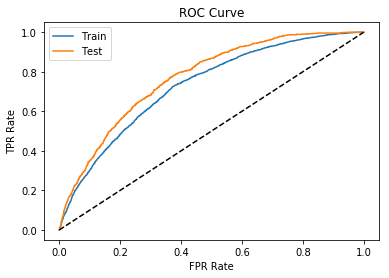

0.3522107349017909
0.4067993914851464


In [37]:
ks_train, ks_test, lr = lr_model(x_train, y_train, x_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0, 0.5, 'freq')

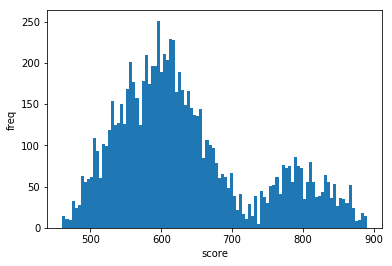

In [41]:
def score_map(p, basepoint, pd0):
    score = basepoint + pd0*(np.log2((1-p)/p))
    return score

basepint = 600
pd0 = 50
test_score = score_map(predict_test, 600, 50)
test['score'] = test_score
plt.hist(test['score'], 100)
plt.xlabel('score')
plt.ylabel('freq')
    